In [1]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import branca
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPoint

In [27]:
ny_shp = gpd.read_file("/home/shade/DS4A/Data/Dataset/Shapes/nta_map_separate.shp")
data = pd.read_csv('/home/shade/DS4A/Data/Dataset/Dataset/uber_trips_2015.csv')

In [28]:
data.head()

,pickup_datetime,pickup_location_id,dispatch_base,affiliate_base
0,2015-05-17 09:47:00,141,B02617,B02617
1,2015-05-17 09:47:00,65,B02617,B02617
2,2015-05-17 09:47:00,100,B02617,B02617
3,2015-05-17 09:47:00,80,B02617,B02774
4,2015-05-17 09:47:00,90,B02617,B02617


In [14]:
df_Points = []

for i in range(len(ny_shp['geometry'])):
    bounds = ny_shp.loc[i, 'geometry'].bounds
    df_filtered = data

    df_filtered = df_filtered[df_filtered['pickup_longitude'] > bounds[0]]
    df_filtered = df_filtered[df_filtered['pickup_longitude'] < bounds[2]]
    df_filtered = df_filtered[df_filtered['pickup_latitude'] > bounds[1]]
    df_filtered = df_filtered[df_filtered['pickup_latitude'] < bounds[3]]
    
    print('df_filtered {}:{}'.format(i, df_filtered.shape))
    
    if i == 0:
        vertical_stack = df_filtered
    else:
        vertical_stack = pd.concat([vertical_stack, df_filtered], axis=0)
        
    vertical_stack.drop_duplicates(keep = False, inplace = True)

df_filtered 0:(3409, 4)
df_filtered 1:(32929, 4)
df_filtered 2:(463, 4)
df_filtered 3:(4670, 4)
df_filtered 4:(2830, 4)
df_filtered 5:(509, 4)
df_filtered 6:(1642, 4)
df_filtered 7:(1697, 4)
df_filtered 8:(810, 4)
df_filtered 9:(600, 4)
df_filtered 10:(1389, 4)
df_filtered 11:(46206, 4)
df_filtered 12:(3158, 4)
df_filtered 13:(1179, 4)
df_filtered 14:(3928, 4)
df_filtered 15:(400, 4)
df_filtered 16:(3128, 4)
df_filtered 17:(327, 4)
df_filtered 18:(3043, 4)
df_filtered 19:(1670, 4)
df_filtered 20:(0, 4)
df_filtered 21:(428, 4)
df_filtered 22:(1117, 4)
df_filtered 23:(4076, 4)
df_filtered 24:(213433, 4)
df_filtered 25:(814, 4)
df_filtered 26:(382, 4)
df_filtered 27:(0, 4)
df_filtered 28:(116908, 4)
df_filtered 29:(348424, 4)
df_filtered 30:(7257, 4)
df_filtered 31:(230, 4)
df_filtered 32:(0, 4)
df_filtered 33:(986, 4)
df_filtered 34:(8704, 4)
df_filtered 35:(1108, 4)
df_filtered 36:(154, 4)
df_filtered 37:(15936, 4)
df_filtered 38:(1057, 4)
df_filtered 39:(5021, 4)
df_filtered 40:(33050,

In [15]:
print (data.shape)
print (vertical_stack.shape)

(4534327, 4)
(1885811, 4)


In [16]:
vertical_stack.to_csv('uber_2014_trips_filtered.csv')

In [18]:
data_Points =[Point(x, y) for x, y in zip(vertical_stack['pickup_longitude'], vertical_stack['pickup_latitude'])]
geo_df = gpd.GeoDataFrame(vertical_stack, geometry=data_Points)

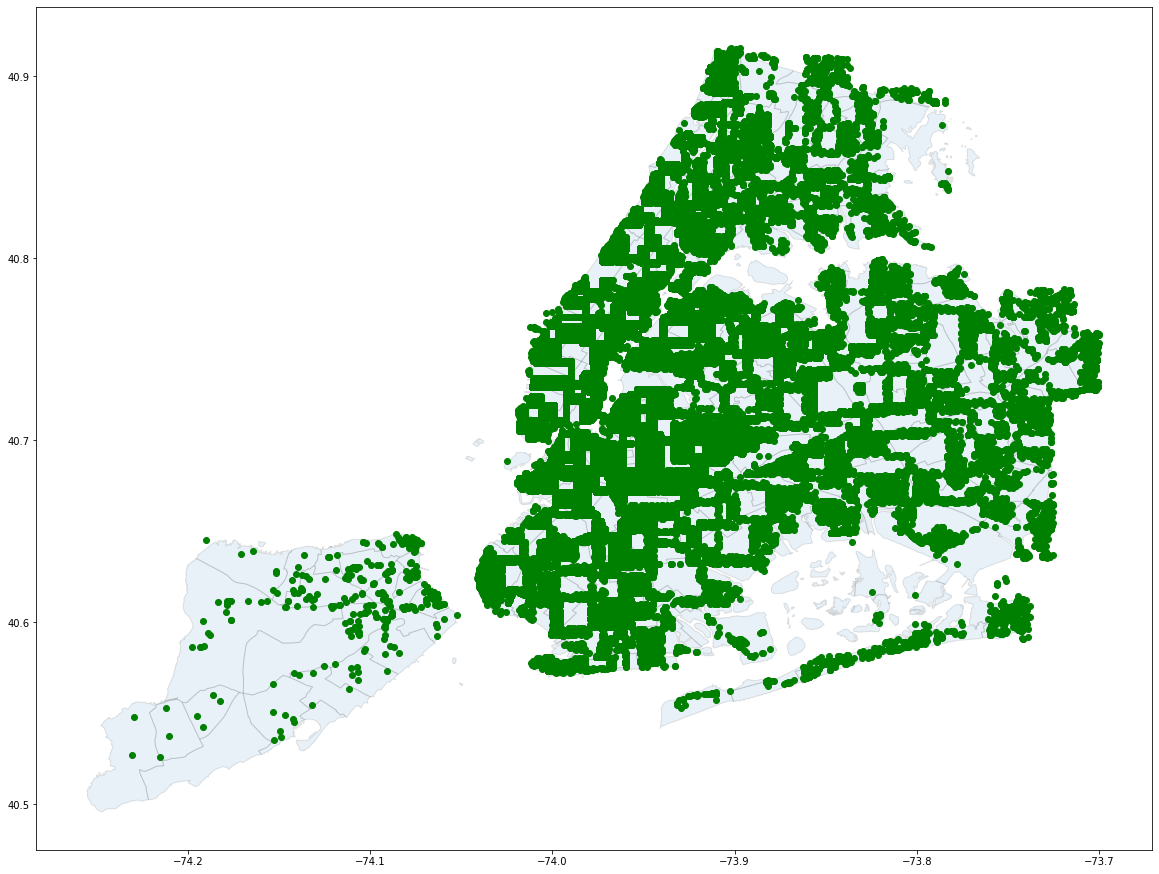

In [19]:
fig, ax = plt.subplots(figsize = (20,16))
ny_shp.plot(figsize=(20,16), alpha=0.1, edgecolor='k', ax=ax)
geo_df.plot(figsize=(20,16), edgecolor='green', color='green', ax=ax)

In [20]:
count = []
ntacode = []
ntaname = []

for i in range(len(ny_shp['geometry'])):
    count.append(geo_df[geo_df.intersects(ny_shp.loc[i, 'geometry'])].shape[0])
    ntacode.append(ny_shp.loc[i, 'ntacode'])
    ntaname.append(ny_shp.loc[i, 'ntaname'])
    if i == 50 or i == 100 or i == 150 or i == 180:
        print (i)

50
100
150
180


In [21]:
df = pd.DataFrame(list(zip(ntacode, ntaname, count)), columns =['ntacode', 'ntaname', 'count']) 
df.to_csv('count_uber_trips_2014_by_nta.csv')

In [22]:
df = pd.read_csv('count_uber_trips_2014_by_nta.csv')

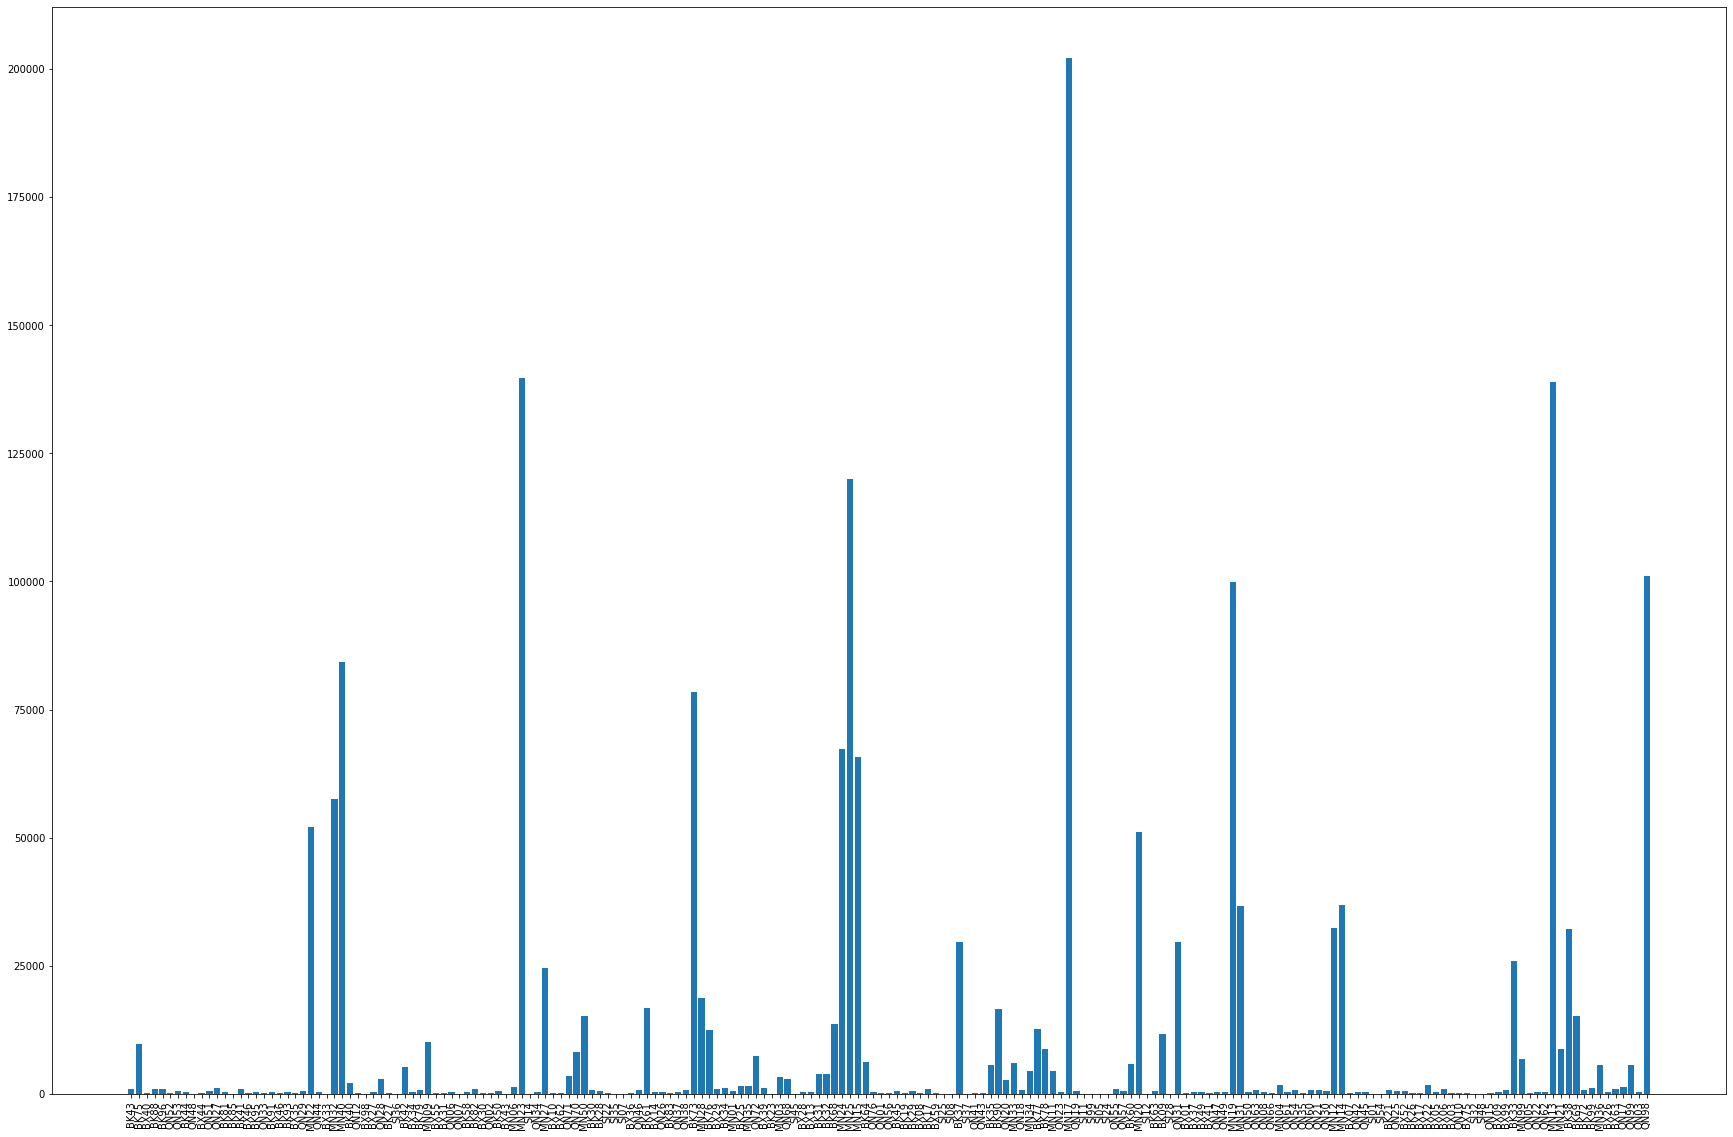

In [23]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=90)
plt.bar(df['ntacode'],df['count'])
plt.savefig('bar_plot', format="png")

In [24]:
df_merge_col = pd.merge(ny_shp, df, left_on=['ntacode'], right_on=['ntacode'])
df_merge_col.head()

,borocode,boroname,countyfips,ntacode,ntaname_x,shape_area,shape_leng,geometry,Unnamed: 0,ntaname_y,count
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160586 40.62916656720947...,0,Midwood,887
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816201 40.70072523469552...,1,Bedford,9736
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380268 40.86170058826308...,2,Fordham South,142
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.9760493559142 40.63127590564666,...",3,Borough Park,996
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,POLYGON ((-73.90855790522774 40.65209593779453...,4,Rugby-Remsen Village,865


In [25]:
min_cn, max_cn = df_merge_col['count'].quantile([0.01,0.99]).apply(round, 2)

colormap = branca.colormap.LinearColormap(
    colors=['white','yellow','orange','red','darkred'],
    #index=beat_cn['count'].quantile([0.2,0.4,0.6,0.8]),b
    vmin=min_cn,
    vmax=max_cn
)

colormap.caption="Total uber 2014 in New York City"

In [26]:
# interactive visualization for beat-specific crime rate in 2017

m_crime = folium.Map(location=[40.738, -73.98],
                        zoom_start=11,
                        tiles="OpenStreetMap")

style_function = lambda x: {
    'fillColor': colormap(x['properties']['count']),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.5
}

stategeo = folium.GeoJson(
    df_merge_col.to_json(),
    name='New York Transport',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['ntacode', 'count'],
        aliases=['ntacode', 'Total uber 2014 Taxi'], 
        localize=True
    )
).add_to(m_crime)

colormap.add_to(m_crime)
m_crime.save('index_uber_2014.html')